# Self Organizing Maps

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import abc

## Map Geometry

Define an abstract base class for an arbitrary map geometry:

In [3]:
class MapGeometry(abc.ABC):
    
    def __init__(self, size):
        self._size = size
        self._separations = None
    
    @property
    def size(self):
        """The flattened size of this map.
        """
        return self._size
    
    @property
    def separations(self):
        """The matrix of pairwise separations between map nodes.
        
        Uses lazy evaluation.  The matrix might be sparse.
        """
        if self._separations is None:
            self._separations = self._calculate_separations()
        return self._separations
    
    @abc.abstractmethod
    def _calculate_separations(self):
        raise NotImplementedError()
        
    @abc.abstractmethod
    def plot(self, values, ax=None, **kwargs):
        """Plot a representation of the specified values for this map.
        
        Parameters
        ----------
        values : array
            1D array of length :attr:`size`    
        ax : matplotlib axis or None
            Plot axis to use, or create a default axis when None.
        kwargs : dict
            Additional plot keyword arguments to pass to the implementation.
        """
        raise NotImplementedError()

Define a rectangular grid with:
 - an arbitrary number of dimensions,
 - arbitrary wrapping along each axis,
 - choice of metric (L0, L1, L2) for computing distance.

In [4]:
class Grid(MapGeometry):
    
    def __init__(self, *signature, metric='L2'):
        """Create a rectilinear grid map geometry.
        
        The grid shape is specified by the absolute values of the signature.        
        A negative value in the signature indicates that distances along the
        corresponding axis are calculated using wrap around.
        """
        shape = [abs(k) for k in signature]
        x = np.empty(shape=shape)
        super(Grid, self).__init__(x.size)
        self._shape = x.shape
        self._wrap = [k < 0 for k in signature]
        if metric not in ('L0', 'L1', 'L2'):
            raise ValueError('Invalid metric "{metric}", should be one of L0, L1, L2.')
        self._metric = metric
        
    @property
    def shape(self):
        return self._shape
    
    @property
    def wrap(self):
        return self._wrap
    
    @property
    def metric(self):
        return self._metric
    
    def _calculate_separations(self):
        ndim = len(self.shape)
        separation = np.zeros(self.shape + self.shape)
        # Loop over axes.
        for k, wrapk in enumerate(self._wrap):
            nk = self.shape[k]
            xk = np.arange(nk)
            # Calculate the the (nk, nk) matrix of absolute integer separations along the k-th axis.
            dxk = np.abs(xk.reshape(nk, 1) - xk)
            if wrapk:
                W = dxk > nk // 2
                dxk[W] *= -1
                dxk[W] += nk
            # Add this axis' contribution to the separation matrix.
            S = [(nk if (j % ndim == k) else 1) for j in range(2 * ndim)]
            dxk = dxk.reshape(S)
            if self._metric == 'L2':
                separation += dxk ** 2
            elif self._metric == 'L1':
                separation += dxk
            elif self._metric == 'L0':
                separation = np.maximum(separation, dxk)
        if self._metric == 'L2':
            # Take sqrt in place.
            np.sqrt(separation, out=separation)
        return separation.reshape(self.size, self.size)
    
    def plot(self, values, ax=None, **kwargs):
        """Plot an image of the input values.
        
        If the grid dimension is > 2, show a slice in the largest
        2 dimensions.
        """
        ndim = len(self.shape)
        if ndim == 1:
            # Plot a single row of values.
            values = values.reshape(1, self.size)
        elif ndim > 2:
            # Plot a slice in the largest 2 dimensions.
            largest = np.argsort(self.shape)[-2:]
            idx = [slice(None) if k in largest else 1 for k in range(ndim)]
            values = values[idx]
        ax = ax or plt.gca()
        ny, nx = values.shape
        ax.imshow(values, interpolation='none', origin='lower',
                  extent=[-0.5, nx - 0.5, -0.5, ny - 0.5], **kwargs)
        ax.axis('off')

### 2D Grid Example

Compare the different wrappings and metrics for a 2D grid:

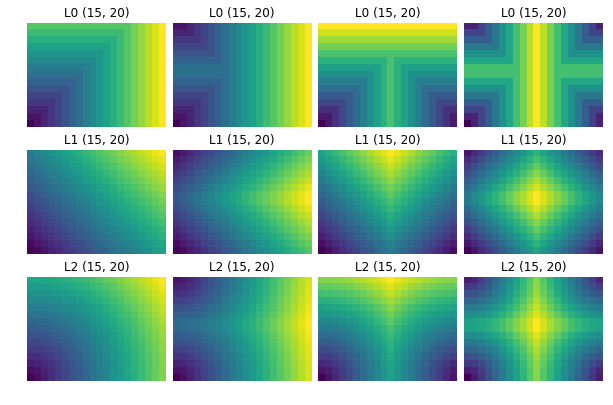

In [5]:
def grid_demo(ny=15, nx=20):
    fig, ax = plt.subplots(3, 4, figsize=(8, 5))
    for i, wrap in enumerate(((1, 1), (-1, 1), (1, -1), (-1, -1))):
        for j, metric in enumerate(('L0', 'L1', 'L2')):
            g = Grid(ny * wrap[0], nx * wrap[1], metric=metric)
            z = g.separations[0].reshape(g.shape)
            g.plot(z, ax=ax[j, i])
            ax[j, i].set_title(f'{g.metric} {g.shape}')
    plt.subplots_adjust(left=0, right=1, wspace=0.05, hspace=0.2, bottom=0, top=1)
  
grid_demo()

## SOM Learning

In [6]:
class SelfOrganizingMap(object):
    
    def __init__(self, mapgeom):
        self._mapgeom = mapgeom
        
    def fit(self, data, maxiter=100, eta=0.5, init='random', seed=123):
        data = np.asarray(data)
        N, D = data.shape
        self._winner = np.empty(N, np.uint32)
        rng = np.random.RandomState(seed)
        if init == 'random':
            sigmas = np.std(data, axis=0)
            self._weights = sigmas.reshape(-1, 1) * rng.normal(size=(D, self._mapgeom.size))
        else:
            raise ValueError(f'Invalid init "{init}".')
        # Calculate mean separation between grid points as a representative large scale.
        large_scale = np.mean(self._mapgeom.separations)
        # Calculate the mean separation between N uniformly distributed points in D dimensions
        # as a representative small scale.
        volume = np.prod(self._mapgeom.shape)
        small_scale = (volume / N) ** (1 / D)
        assert small_scale < large_scale, 'Check the scales!'
        scale = large_scale
        dscale = (small_scale / large_scale) ** (1 / maxiter)
        for i in range(maxiter):
            loss = 0.
            for j, x in enumerate(data):
                # Calculate the Euclidean data-space distance squared between x and
                # each map site's weight vector.
                dx = x.reshape(-1, 1) - self._weights
                distsq = np.sum(dx ** 2, axis=0)
                # Find the map site with the smallest distance (largest dot product).
                self._winner[j] = k = np.argmin(distsq)
                # The loss is the sum of smallest (data space) distances for each data point.
                loss += np.sqrt(distsq[k])
                # Update all weights (dz are map-space distances).
                dz = self._mapgeom.separations[k]
                self._weights += eta * np.exp(-0.5 * (dz / scale) ** 2) * dx
            yield i, loss
            # Lower the scale for the next iteration.
            scale *= dscale

### RGB Color Example

In [7]:
def colors_demo(ncolors=25, nmap=-50, niter=100, eta=0.1):
    
    # Lookup all named colors in matplotlib.
    color_dict = {name: matplotlib.colors.to_rgba(color)[:3] for name, color in matplotlib.colors.CSS4_COLORS.items()}
    
    # Use the first ncolors.
    color_names = sorted(color_dict.keys())[:ncolors]
    colors = [color_dict[name] for name in color_names]
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(colors, maxiter=niter, eta=eta):
        losses.append(loss)

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    ax[0].imshow(img.reshape(abs(nmap), abs(nmap), 3), interpolation='none', origin='lower')
    for i, (color, name) in enumerate(zip(colors, color_names)):
        k = som._winner[i]
        y, x  = np.unravel_index(k, som._mapgeom.shape)
        ax[0].text(x, y, name, horizontalalignment='center',
                   verticalalignment='center', fontsize='medium')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()

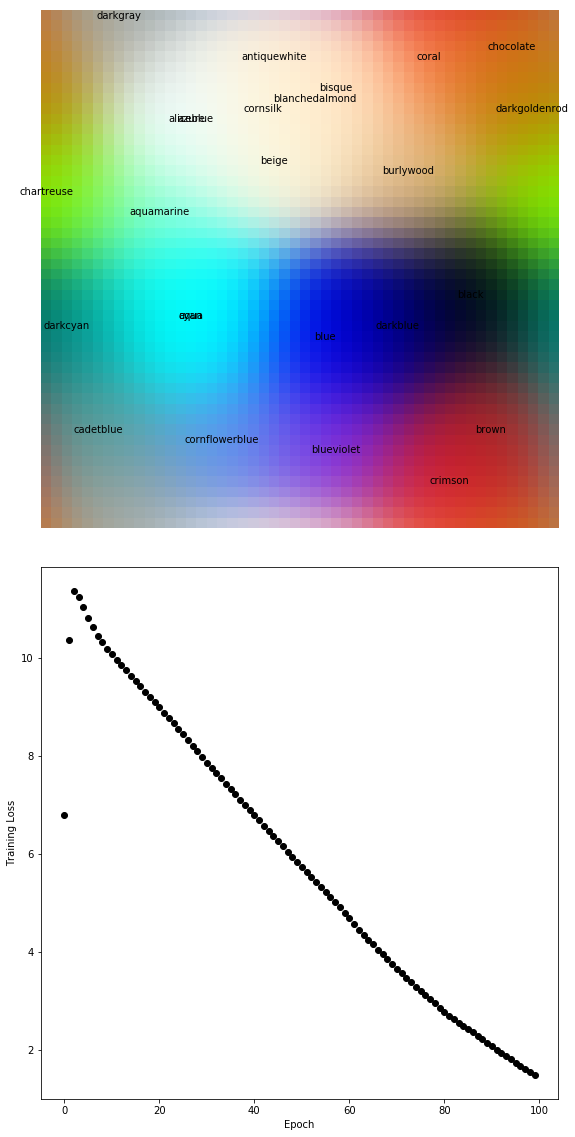

In [8]:
colors_demo()